In [19]:
!pip install matplotlib

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [20]:
import os
import numpy as np

CLASSES_LIST = ["Real", "Fake"]
KAGGLE_INPUT_DIR = '/kaggle/input'

def load_numpy_file(filename):
    full_path = os.path.join(KAGGLE_INPUT_DIR, filename)
    if os.path.exists(full_path):
        return np.load(full_path)
    else:
        print(f"File not found: {full_path}")
        return None

def print_class_distribution(data, data_type):
    if data is not None:
        if data.ndim > 1 and data.shape[1] > 1:  # Check if data is one-hot encoded
            labels = np.argmax(data, axis=1)
        else:
            labels = data.flatten()
        
        unique, counts = np.unique(labels, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        
        print(f"\n{data_type} data class distribution:")
        for class_label, count in class_distribution.items():
            print(f"Class {CLASSES_LIST[int(class_label)]}: {count}")
        print(f"Total {data_type.lower()} samples: {len(labels)}")
    else:
        print(f"{data_type} data not available.")

train_features = load_numpy_file('prepro-82-no-aug/train_features_600videos_128pxl_20seq.npy')
train_labels = load_numpy_file('prepro-82-no-aug/train_labels_600videos_128pxl_20seq.npy')  
val_features = load_numpy_file('prepro-82-no-aug/val_features_600videos_128pxl_20seq.npy')
val_labels = load_numpy_file('prepro-82-no-aug/val_labels_600videos_128pxl_20seq.npy')

print("Data shapes:")
print(f"Train features shape: {train_features.shape if train_features is not None else 'Not available'}")
print(f"Train labels shape: {train_labels.shape if train_labels is not None else 'Not available'}")
print(f"Validation features shape: {val_features.shape if val_features is not None else 'Not available'}")
print(f"Validation labels shape: {val_labels.shape if val_labels is not None else 'Not available'}")

print_class_distribution(train_labels, "Training")
print_class_distribution(val_labels, "Validation")

def print_detailed_info(features, labels, data_type):
    if features is not None and labels is not None:
        print(f"\n{data_type} data checks:")
        print(f"Number of videos: {features.shape[0]}")
        print(f"Number of frames per video: {features.shape[1]}")
        print(f"Frame dimensions: {features.shape[2]}x{features.shape[3]}")
        print(f"Number of channels: {features.shape[4]}")
        print(f"Total number of frames: {features.shape[0] * features.shape[1]}")
        print(f"Data type of features: {features.dtype}")
        print(f"Data type of labels: {labels.dtype}")
        print(f"Min value in features: {np.min(features)}")
        print(f"Max value in features: {np.max(features)}")
        
        frame_means = np.mean(features, axis=(0, 1, 2, 3))
        frame_stds = np.std(features, axis=(0, 1, 2, 3))
        print(f"Mean values per channel: {frame_means}")
        print(f"Standard deviation per channel: {frame_stds}")

print_detailed_info(train_features, train_labels, "Training")
print_detailed_info(val_features, val_labels, "Validation")

Data shapes:
Train features shape: (480, 20, 128, 128, 3)
Train labels shape: (480,)
Validation features shape: (120, 20, 128, 128, 3)
Validation labels shape: (120,)

Training data class distribution:
Class Real: 240
Class Fake: 240
Total training samples: 480

Validation data class distribution:
Class Real: 60
Class Fake: 60
Total validation samples: 120

Training data checks:
Number of videos: 480
Number of frames per video: 20
Frame dimensions: 128x128
Number of channels: 3
Total number of frames: 9600
Data type of features: float64
Data type of labels: float32
Min value in features: 0.0
Max value in features: 1.0
Mean values per channel: [0.3203215  0.36498502 0.56297952]
Standard deviation per channel: [0.13619765 0.14549926 0.20164232]

Validation data checks:
Number of videos: 120
Number of frames per video: 20
Frame dimensions: 128x128
Number of channels: 3
Total number of frames: 2400
Data type of features: float64
Data type of labels: float32
Min value in features: 0.0
Max v

In [21]:
!pip install keras==2.15.0

In [22]:
import tensorflow as tf

print(tf.__version__)

2.15.0


# import

In [23]:
import numpy as np  
import tensorflow as tf  
from tensorflow.keras.models import Model  
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Flatten  
from tensorflow.keras.applications import Xception  
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad 
from tensorflow.keras.callbacks import ModelCheckpoint  
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from tensorflow.keras.regularizers import l2  
import matplotlib.pyplot as plt  
import seaborn as sns  

# paths and constans

In [24]:
SEQUENCE_LENGTH = 20 
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128  
SAVE_DIR = '/kaggle/working'  

X_train = np.load('/kaggle/input/prepro-82-no-aug/train_features_600videos_128pxl_20seq.npy')  
y_train = np.load('/kaggle/input/prepro-82-no-aug/train_labels_600videos_128pxl_20seq.npy')  
X_val = np.load('/kaggle/input/prepro-82-no-aug/val_features_600videos_128pxl_20seq.npy')  
y_val = np.load('/kaggle/input/prepro-82-no-aug/val_labels_600videos_128pxl_20seq.npy')  


# define model

In [25]:
def create_model():  
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))  
    
    for layer in base_model.layers[:20]:  
        layer.trainable = False  
    
    inputs = Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  
    
    x = TimeDistributed(base_model)(inputs)  
    x = TimeDistributed(GlobalAveragePooling2D())(x)  
    
    x = LSTM(256, return_sequences=True)(x)  
    x = LSTM(128)(x)  
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  
    x = BatchNormalization()(x)  
    
    outputs = Dense(1, activation='sigmoid')(x)  
    
    model = Model(inputs=inputs, outputs=outputs)  
    
    optimizer = Adam(learning_rate=1e-4)  
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])  
    
    return model


# initialize

In [26]:
model = create_model()  
model.summary()  

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 128, 128, 3   0         
                             )]                                  
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 4, 4, 2048)    20861480  
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 2048)          0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 20, 256)           2360320   
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                           

# train model

In [27]:
callbacks = [  
    ModelCheckpoint(filepath=f'{SAVE_DIR}/model_at_end_of_epoch.keras', save_best_only=False, save_freq='epoch', verbose=1)  
]  

history = model.fit(  
    X_train, y_train,  
    validation_data=(X_val, y_val),  
    epochs=50,  
    batch_size=16,  
    callbacks=callbacks,  
    verbose=1  
)  


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 1.4550 - accuracy: 0.6917
Epoch 1: saving model to /kaggle/working/model_at_end_of_epoch.keras
30/30 [==============================] - 52s 1s/step - loss: 1.4550 - accuracy: 0.6917 - val_loss: 1.5621 - val_accuracy: 0.4917
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.9125
Epoch 2: saving model to /kaggle/working/model_at_end_of_epoch.keras
30/30 [==============================] - 28s 940ms/step - loss: 1.0623 - accuracy: 0.9125 - val_loss: 1.4560 - val_accuracy: 0.6583
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.9771
Epoch 3: saving model to /kaggle/working/model_at_end_of_epoch.keras
30/30 [==============================] - 28s 939ms/step - loss: 0.9049 - accuracy: 0.9771 - val_loss: 1.3688 - val_accuracy: 0.7167
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 0.8594 - accuracy: 0.9937
Epoch 4: saving model to

In [28]:
model.save(f'{SAVE_DIR}/best_model.h5')  

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# plot acc n loss

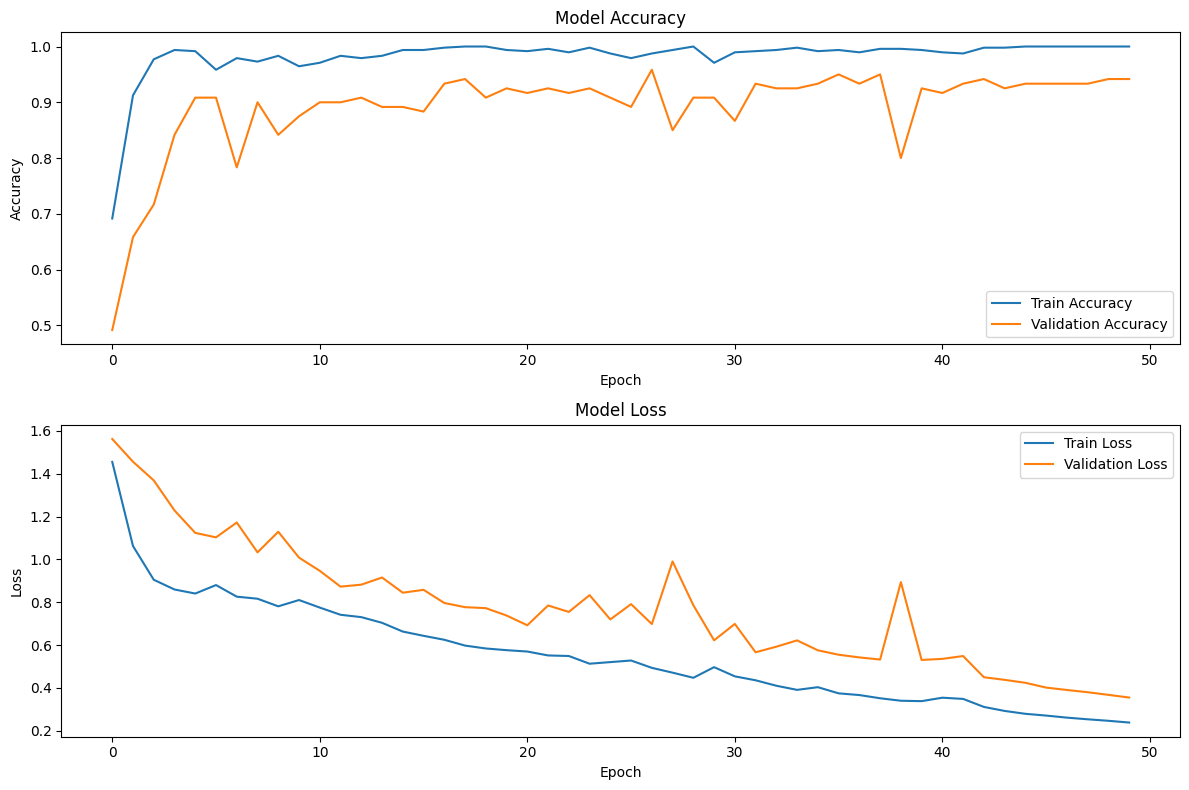

In [29]:
plt.figure(figsize=(12, 8))  

plt.subplot(2, 1, 1)  # Adding a subplot for accuracy  
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Model Accuracy')  
plt.xlabel('Epoch')  
plt.ylabel('Accuracy')  
plt.legend()  

# plot loss 
plt.subplot(2, 1, 2)  # Adding a subplot for loss  
plt.plot(history.history['loss'], label='Train Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('Model Loss')  
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.legend()  

plt.tight_layout()  
plt.show()  


# eval cm n metrics

4/4 [==============================] - 3s 300ms/step
Accuracy: 0.9417
Precision: 0.9492
Recall: 0.9333
F1 Score: 0.9412


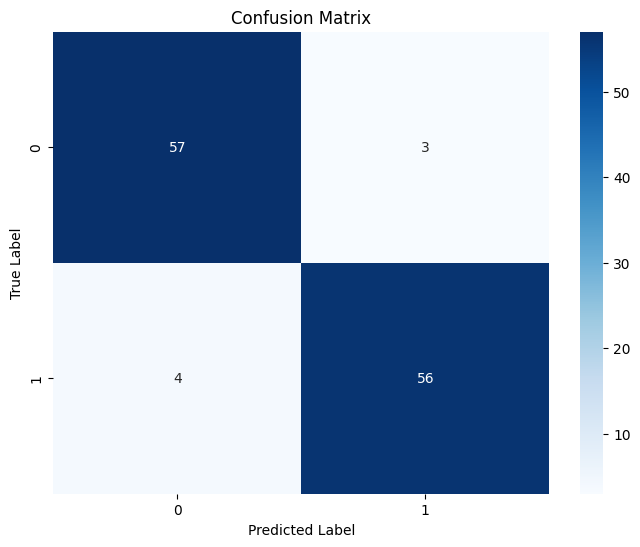

In [30]:
y_pred = model.predict(X_val)  
y_pred_classes = (y_pred > 0.5).astype(int)  

# Calculate confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)

# Calculate metrics
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = precision_score(y_val, y_pred_classes)
recall = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# roc auc

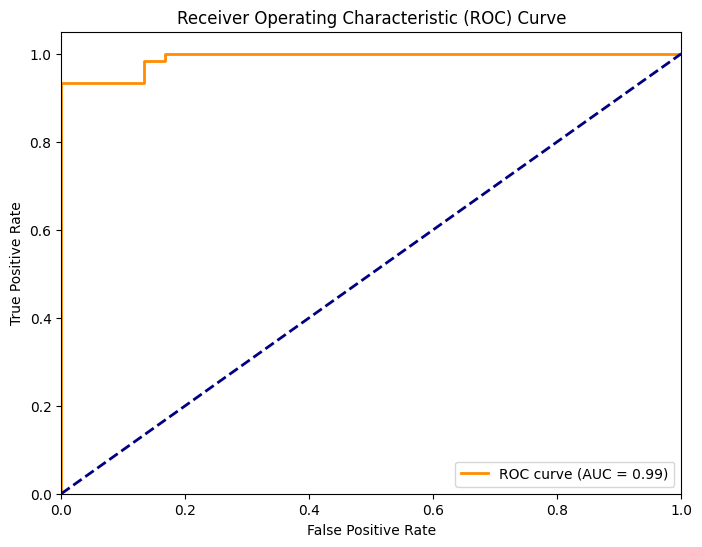

ROC AUC Score: 0.9906


In [31]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


# testing multiple vids

In [32]:
!pip install mtcnn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [33]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 20
FRAME_SKIP = 2
SAVE_DIR = '/kaggle/working'
LOAD_DIR = '/kaggle/input/prepro-82-no-aug'
TEST_DIR = '/kaggle/input/test-vid/test-kaggle'
MODEL_PATH = '/kaggle/working/best_model.h5'


In [34]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    total_frames_needed = SEQUENCE_LENGTH * FRAME_SKIP
    frame_step = max(video_frames_count // total_frames_needed, 1)
    detector = MTCNN()

    # extract first frame
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, 0)
    success, first_frame = video_reader.read()
    
    # extract frames
    for i in range(0, total_frames_needed, FRAME_SKIP):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
        success, frame = video_reader.read()
        if not success:
            break

        faces = detector.detect_faces(frame)
        if faces:
            x, y, width, height = faces[0]['box']
            frame = frame[y:y+height, x:x+width]

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list, first_frame 

In [35]:
# display
def show_frame_and_prediction(video_name, frame, prediction):
    # convert to rgb
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Frame from {video_name}")
    plt.show()
    # predict
    if prediction > 0.5:
        print(f"Prediction: FAKE (Deepfake) with confidence {prediction:.2f}")
    else:
        print(f"Prediction: REAL with confidence {1 - prediction:.2f}")

def predict_on_video(model, video_path):
    frames, first_frame = frames_extraction(video_path)
    if len(frames) != SEQUENCE_LENGTH:
        print(f"Error: Could not extract {SEQUENCE_LENGTH} frames from {video_path}")
        return None, first_frame
    
    frames = np.expand_dims(frames, axis=0)
    prediction = model.predict(frames)[0][0]
    return prediction, first_frame 

model = load_model(MODEL_PATH)

1/1 [==============================] - 3s 3s/step


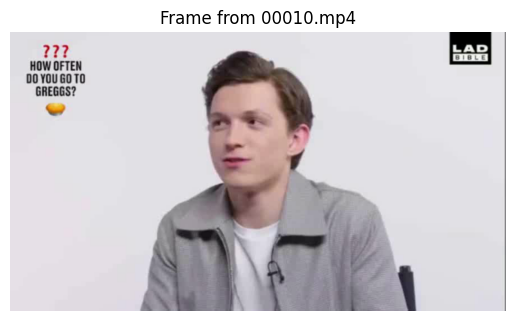

Prediction: REAL with confidence 0.73
1/1 [==============================] - 0s 28ms/step


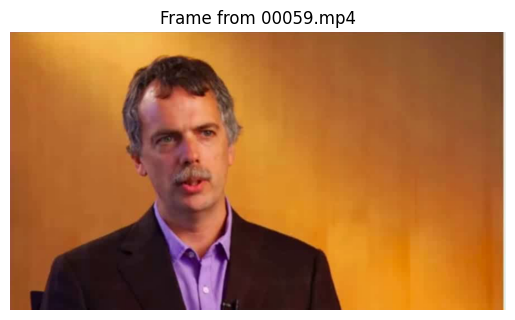

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 28ms/step


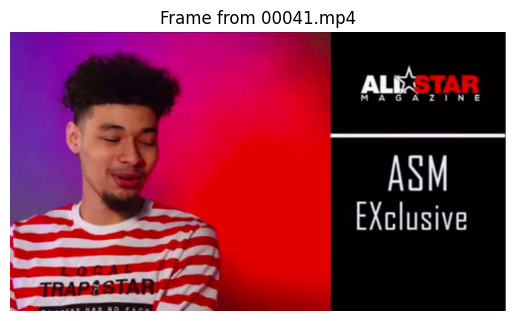

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 28ms/step


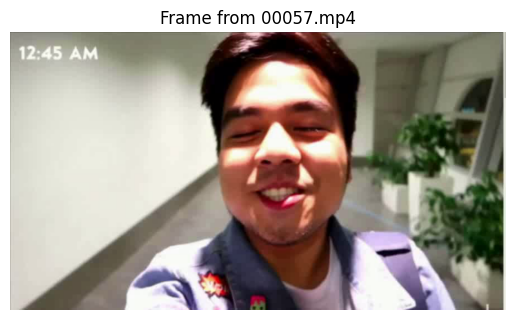

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 27ms/step


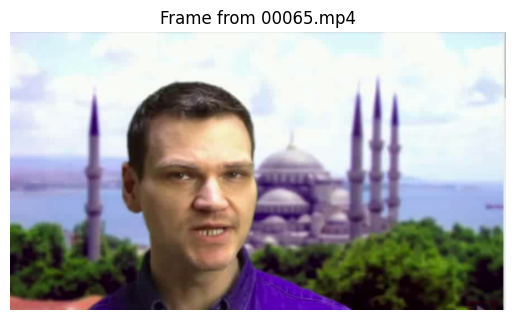

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 27ms/step


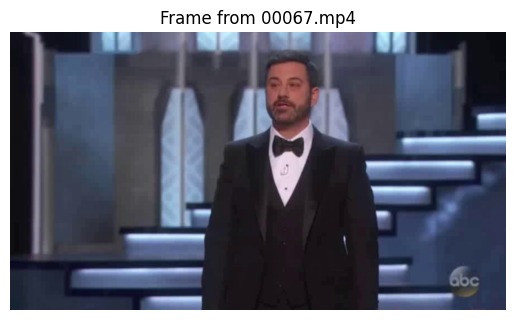

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 27ms/step


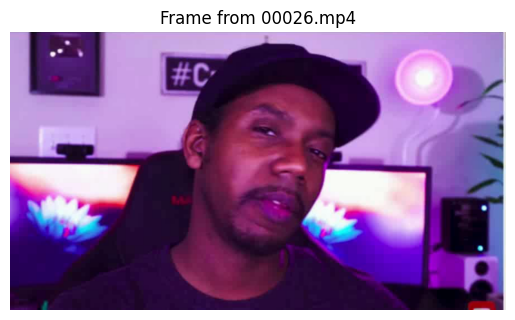

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 27ms/step


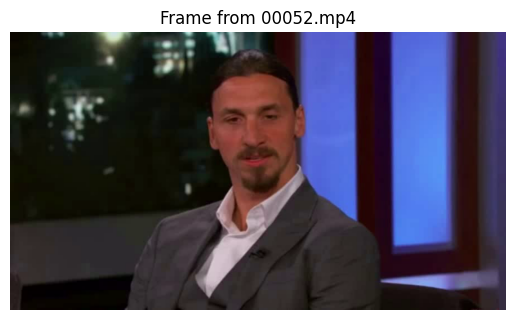

Prediction: REAL with confidence 0.55
1/1 [==============================] - 0s 27ms/step


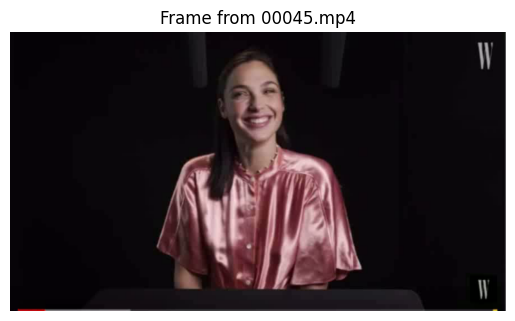

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 27ms/step


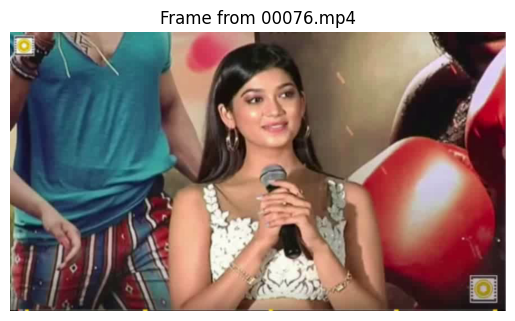

Prediction: REAL with confidence 1.00
1/1 [==============================] - 0s 26ms/step


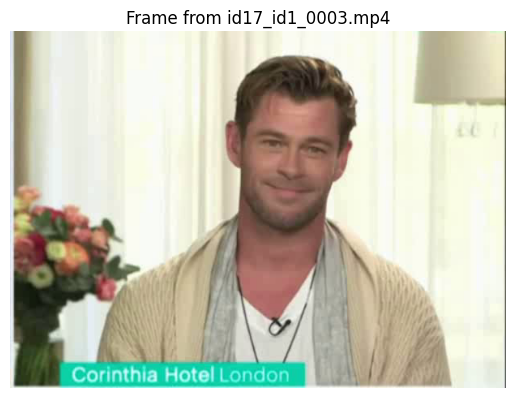

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 28ms/step


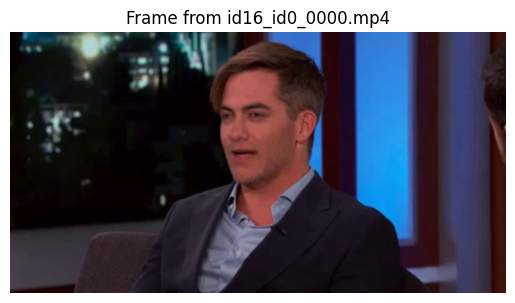

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 27ms/step


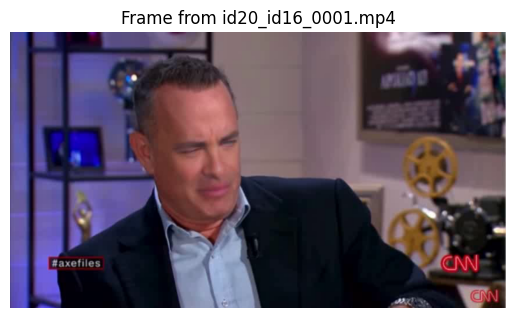

Prediction: FAKE (Deepfake) with confidence 0.99
1/1 [==============================] - 0s 28ms/step


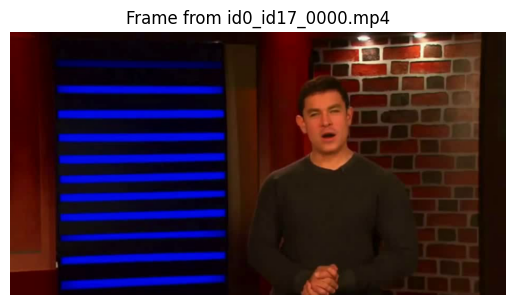

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 26ms/step


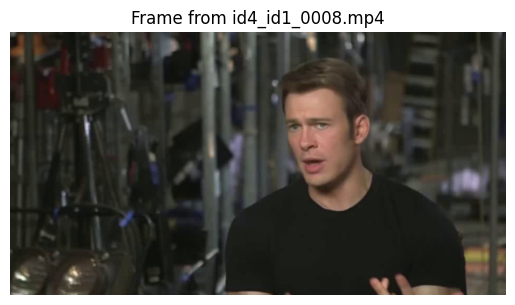

Prediction: FAKE (Deepfake) with confidence 0.96
1/1 [==============================] - 0s 25ms/step


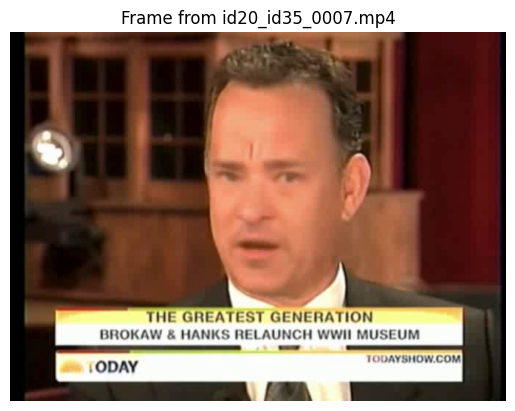

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 25ms/step


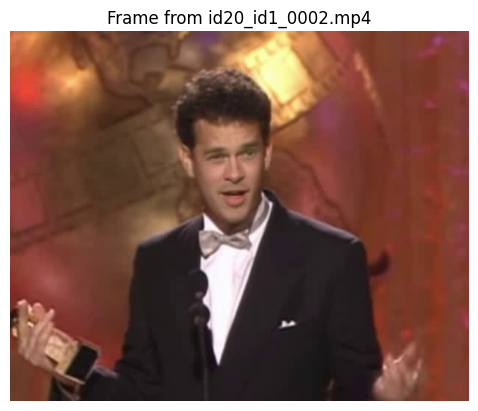

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 27ms/step


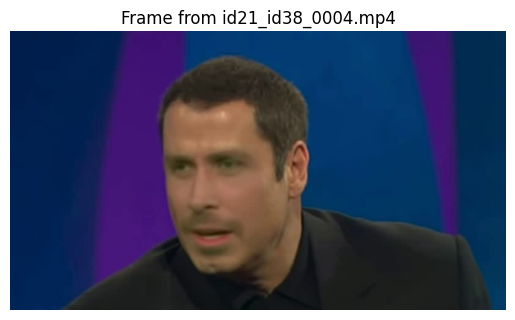

Prediction: FAKE (Deepfake) with confidence 1.00
1/1 [==============================] - 0s 26ms/step


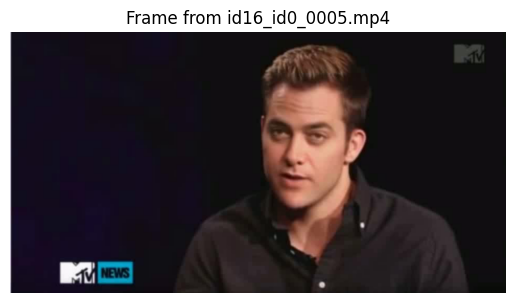

Prediction: FAKE (Deepfake) with confidence 0.71
1/1 [==============================] - 0s 27ms/step


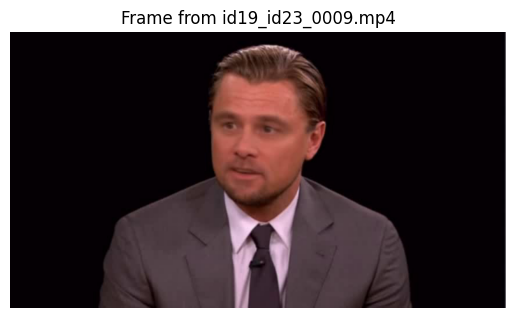

Prediction: FAKE (Deepfake) with confidence 1.00

Test Set Evaluation:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
ROC AUC Score: 1.0000


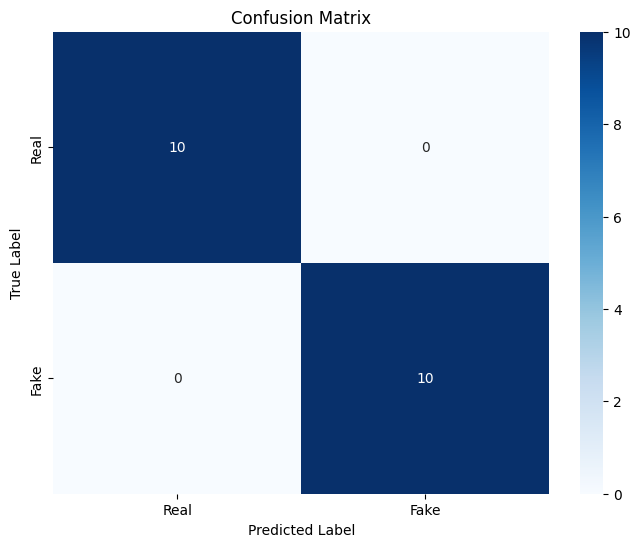

In [36]:
def evaluate_test_set():
    true_labels = []
    predictions = []

    for category in ['Real', 'Fake']:
        category_dir = os.path.join(TEST_DIR, category)
        for video_file in os.listdir(category_dir):
            if video_file.endswith('.mp4'):
                video_path = os.path.join(category_dir, video_file)
                pred, first_frame = predict_on_video(model, video_path)
                if pred is not None:
                    predictions.append(pred)
                    true_labels.append(1 if category == 'Fake' else 0)

                    # Display the first frame and the prediction below it
                    show_frame_and_prediction(video_file, first_frame, pred)

    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    y_pred_classes = (predictions > 0.5).astype(int)
    accuracy = accuracy_score(true_labels, y_pred_classes)
    precision = precision_score(true_labels, y_pred_classes)
    recall = recall_score(true_labels, y_pred_classes)
    f1 = f1_score(true_labels, y_pred_classes)
    roc_auc = roc_auc_score(true_labels, predictions)

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # cm
    cm = confusion_matrix(true_labels, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

evaluate_test_set()